## Fase 2 Analisis exploratorio de datos EDA


Autor: Alejandro Arteaga Jaramillo

Se importan las librerias necesarias

In [1]:
import yaml
import psycopg2 
from psycopg2 import sql
from sqlalchemy import create_engine, text
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Se configura el acceso a la base de datos con el archivo .yaml creado con las credenciales correctas para su acceso

In [2]:
def load_config(file_path="config.yaml"):
    with open(file_path, "r") as file:
        return yaml.safe_load(file)

In [3]:
config = load_config()
db_config = config["database"]

# Load credentials
db_user = db_config["user"]
db_password = db_config["password"]
db_host = db_config["host"]
db_port = db_config["port"]
db_name = db_config["name"]

# DB connection
conn = psycopg2.connect(
    dbname="postgres",
    user=db_user,
    password=db_password,
    host=db_host,
    port=db_port
)
conn.autocommit = True

Se realiza la extraccion de la tabla almacenada en Mysql y se almacena en un nuevo dataframe donde se realizaran las transformaciones

In [4]:
engine = create_engine(f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}")

df_eda = pd.read_sql("tabla_proyecto_etl2",con = engine)

print(df_eda.head())

       id                    title  vote_average  vote_count    status  \
0  157336             Interstellar         8.417       32571  Released   
1   19995                   Avatar         7.573       29815  Released   
2   24428             The Avengers         7.710       29166  Released   
3  293660                 Deadpool         7.606       28894  Released   
4  118340  Guardians of the Galaxy         7.906       26638  Released   

  release_date     revenue  runtime  adult     budget  ... original_language  \
0    11/5/2014   701729206      169  False  165000000  ...                en   
1   12/15/2009  2923706026      162  False  237000000  ...                en   
2    4/25/2012  1518815515      143  False  220000000  ...                en   
3     2/9/2016   783100000      108  False   58000000  ...                en   
4    7/30/2014   772776600      121  False  170000000  ...                en   

            original_title                                           overv

## Transformaciones 
Una vez almacenada la tabla en el nuevo DataFrame, se llevan a cabo diversas transformaciones para optimizar el análisis y asegurar la calidad de los datos. Estas transformaciones incluyen:

- Eliminación de datos irrelevantes: Se eliminan filas que contienen información insuficiente o irrelevante para el análisis, como registros sin valores esenciales (presupuesto, ingresos, calificaciones, etc.).

- Conversión de formatos numéricos: Algunas variables numéricas contienen una cantidad excesiva de decimales, por lo que se redondean para facilitar su interpretación y visualización.

- Extracción de información de columnas complejas: Algunas columnas contienen listas de elementos separados por comas, como los estudios de producción o los idiomas hablados en la película. Se realiza un proceso de extracción y limpieza para que la información sea más accesible.

- Filtrado de películas según relevancia: Se excluyen películas clasificadas como "adulto" que no aportan valor al análisis de tendencias generales en la industria. Además, se filtran únicamente aquellas películas que han sido estrenadas, eliminando registros con estado "upcoming" o similares.

In [5]:
# Se cambia el tipo de dato de la columna "release_date" a un tipo de dato "date" con el fin de separar los dias, meses y años de estreno.
df_eda["release_date"] = pd.to_datetime(df_eda["release_date"], errors="coerce")

print(df_eda.dtypes)

id                               int64
title                           object
vote_average                   float64
vote_count                       int64
status                          object
release_date            datetime64[ns]
revenue                          int64
runtime                          int64
adult                             bool
budget                           int64
imdb_id                         object
original_language               object
original_title                  object
overview                        object
popularity                     float64
tagline                         object
genres                          object
production_companies            object
production_countries            object
spoken_languages                object
keywords                        object
dtype: object


In [6]:
#Se extrae de la feature "release_date" el dia, mes, año y se almacenan en las columnas especificadas, posteriormente se borra la columna "release_date"
df_eda["release_year"] = df_eda["release_date"].dt.year
df_eda["release_month"] = df_eda["release_date"].dt.month
df_eda["release_day"] = df_eda["release_date"].dt.day

df_eda.drop(columns=["release_date"], inplace=True)


In [7]:
#Se convierte a enterno los vaores de año, mes y dia creados
df_eda["release_year"] = df_eda["release_year"].fillna(0).astype(int)
df_eda["release_month"] = df_eda["release_month"].fillna(0).astype(int) 
df_eda["release_day"] = df_eda["release_day"].fillna(0).astype(int) 

In [8]:
df_eda = df_eda[df_eda["release_year"] != 0]

In [9]:
print(df_eda.dtypes)

id                        int64
title                    object
vote_average            float64
vote_count                int64
status                   object
revenue                   int64
runtime                   int64
adult                      bool
budget                    int64
imdb_id                  object
original_language        object
original_title           object
overview                 object
popularity              float64
tagline                  object
genres                   object
production_companies     object
production_countries     object
spoken_languages         object
keywords                 object
release_year              int64
release_month             int64
release_day               int64
dtype: object


In [10]:
#Se eliminan las filas que sean catalogadas como peliculas de adulto.

df_eda = df_eda[df_eda["adult"] != True]

In [11]:
# Se eliminan los features que no se aportan a un buen analisis
df_eda.drop(columns=["id"], inplace=True)
df_eda.drop(columns=["imdb_id"], inplace=True)
df_eda.drop(columns=["overview"], inplace=True)
df_eda.drop(columns=["tagline"], inplace=True)
df_eda.drop(columns=["keywords"], inplace=True)
df_eda.drop(columns=["production_countries"], inplace=True)
df_eda.drop(columns=["original_title"], inplace=True)


In [12]:
#Se redondan los valores de vote_Average a un solo decimal

df_eda["vote_average"] = df_eda["vote_average"].round(1)

In [13]:
# Se eliminan los valores que tengan valores de 0.0 en voto
df_eda = df_eda[df_eda["vote_average"] != 0.0]

In [14]:
# Se pasa el valor de "Runtime" a un valor de horas

df_eda["runtime"] = df_eda["runtime"].apply(lambda x: f"{x // 60}:{x % 60:02d}")


In [15]:
#Para terminos de visualizacion, se aplica un formato a los valores de presupuesto y ganancias, pero no se eliminan ni se cambia el formatooriginal de la columna padre
# ya que esta nos ayuda a graficar y catalogar si las peliculas son o no rentables

# Función para formatear números con un decimal
def formato_(valor):
    if valor >= 1_000_000_000:  # Billones (B)
        return f"{valor / 1_000_000_000:.1f}B"
    elif valor >= 1_000_000:  # Millones (M)
        return f"{valor / 1_000_000:.1f}M"
    elif valor >= 1_000:  # Miles (K)
        return f"{valor / 1_000:.1f}K"
    else:
        return str(valor)  # Número sin cambios

# Aplicar la función a la columna
df_eda["budget_formato"] = df_eda["budget"].apply(formato_)
df_eda["reveneu_formato"] = df_eda["revenue"].apply(formato_)
print(df_eda.head(5))


                     title  vote_average  vote_count    status     revenue  \
0             Interstellar           8.4       32571  Released   701729206   
1                   Avatar           7.6       29815  Released  2923706026   
2             The Avengers           7.7       29166  Released  1518815515   
3                 Deadpool           7.6       28894  Released   783100000   
4  Guardians of the Galaxy           7.9       26638  Released   772776600   

  runtime  adult     budget original_language  popularity  \
0    2:49  False  165000000                en     140.241   
1    2:42  False  237000000                en      79.932   
2    2:23  False  220000000                en      98.082   
3    1:48  False   58000000                en      72.735   
4    2:01  False  170000000                en      33.255   

                                        genres  \
0            Adventure, Drama, Science Fiction   
1  Action, Adventure, Fantasy, Science Fiction   
2           Sc

In [16]:
# Se filtran los datos de la columna "status" y se dejan unicamente los "released"

df_eda=df_eda[df_eda["status"] == "Released"]

In [17]:
df_eda.shape

(168889, 18)

In [18]:
# Se extraen del listado de generos y se almacenan en columnas independientes

df_split = df_eda["genres"].str.split(",", expand=True).iloc[:,:5]


df_split.columns = [f"genre_{i+1}" for i in range(df_split.shape[1])]


df_try = df_eda.join(df_split)


print(df_split.columns)

Index(['genre_1', 'genre_2', 'genre_3', 'genre_4', 'genre_5'], dtype='object')


In [19]:
#Se filtran los valores donde el genero_1 sea 0 y valores nan
df_try = df_try[df_try["genre_1"] != "0"]
df_try = df_try.dropna(subset=['genre_1'])

In [20]:
# Se extraen del listado de spoken languages se almacenan en columnas independientes

df_split2 = df_try["spoken_languages"].str.split(",", expand=True).iloc[:,:5]


df_split2.columns = [f"languaje_{i+1}" for i in range(df_split2.shape[1])]


df_eda_F = df_try.join(df_split2)

print(df_split2.columns)
df_eda_F.shape

Index(['languaje_1', 'languaje_2', 'languaje_3', 'languaje_4', 'languaje_5'], dtype='object')


(168889, 28)

In [21]:
#Se eliminan las filas que tengan en la columna "Production companies" un valor de 0
df_eda_F = df_eda_F[~df_eda_F["production_companies"].astype(str).isin(["0"])]
df_eda_F.shape

(168889, 28)

In [22]:
# Se extraen del listado de production_companies se almacenan en columnas independientes

df_split3 = df_eda_F["production_companies"].str.split(",", expand=True).iloc[:,:5]


df_split3.columns = [f"produces_{i+1}" for i in range(df_split3.shape[1])]


df_eda_F2 = df_eda_F.join(df_split3)

print(df_split3.columns)
df_eda_F2.shape

Index(['produces_1', 'produces_2', 'produces_3', 'produces_4', 'produces_5'], dtype='object')


(168889, 33)

In [23]:
#Se creae la columna que confirma si la pelicula tiene o no profit, con un true en caso de que si y un false en caso contrario
df_eda_F2["has_profit"] = (df_eda_F2["revenue"] - df_eda_F2["budget"]) > 0


In [24]:
print(df_eda_F2.head(5))

                     title  vote_average  vote_count    status     revenue  \
0             Interstellar           8.4       32571  Released   701729206   
1                   Avatar           7.6       29815  Released  2923706026   
2             The Avengers           7.7       29166  Released  1518815515   
3                 Deadpool           7.6       28894  Released   783100000   
4  Guardians of the Galaxy           7.9       26638  Released   772776600   

  runtime  adult     budget original_language  popularity  ... languaje_2  \
0    2:49  False  165000000                en     140.241  ...       None   
1    2:42  False  237000000                en      79.932  ...    Spanish   
2    2:23  False  220000000                en      98.082  ...      Hindi   
3    1:48  False   58000000                en      72.735  ...       None   
4    2:01  False  170000000                en      33.255  ...       None   

  languaje_3 languaje_4  languaje_5          produces_1  \
0       N

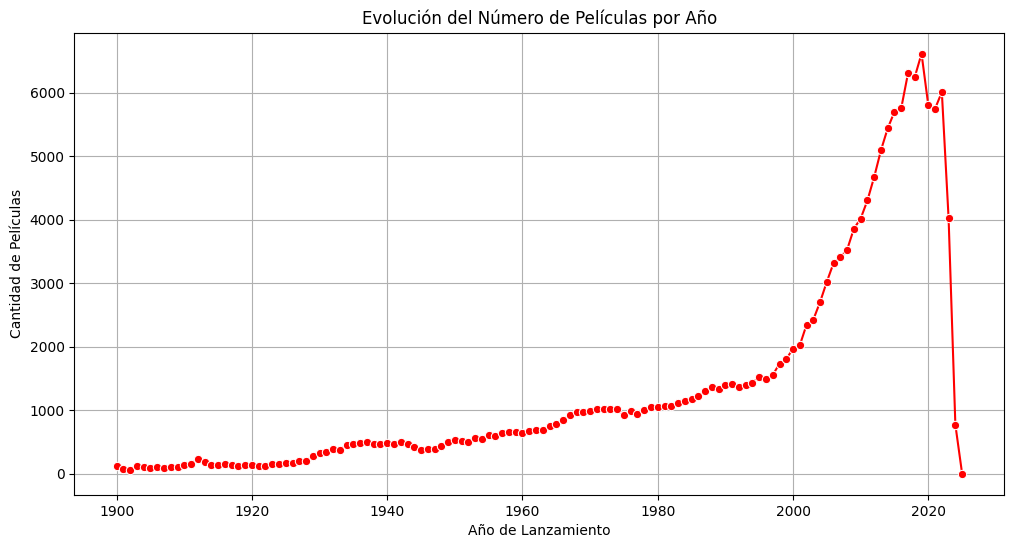

In [25]:
#Se crea un grafico donde se visualiza la evolucion del numero de peliculas por año

# Contar películas por año
movies_per_year = df_eda_F2["release_year"].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x=movies_per_year.index, y=movies_per_year.values, marker="o", color="red")
plt.title("Evolución del Número de Películas por Año")
plt.xlabel("Año de Lanzamiento")
plt.ylabel("Cantidad de Películas")
plt.grid()
plt.show()

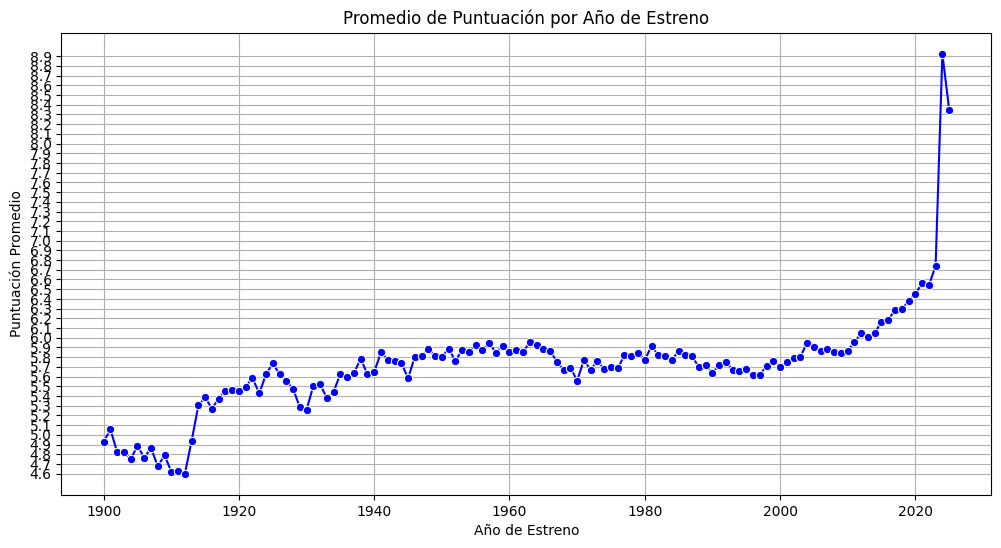

In [26]:
#Se crea un grafico donde se ve la evolucion de la parte critica del publico a medida que los años pasan 
df_avg_votes = df_eda_F2.groupby("release_year")["vote_average"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x=df_avg_votes["release_year"], y=df_avg_votes["vote_average"], marker='o', color='blue')

plt.title("Promedio de Puntuación por Año de Estreno")
plt.xlabel("Año de Estreno")
plt.ylabel("Puntuación Promedio")
plt.grid()

# Ajuste de los valores del eje Y con un decimal
y_min = round(df_avg_votes["vote_average"].min(), 1)
y_max = round(df_avg_votes["vote_average"].max(), 1) + 0.1  
plt.yticks(np.round(np.arange(y_min, y_max, 0.1), 1))  

plt.show()



C:\Users\Alejandro Arteaga\AppData\Local\Temp\ipykernel_1280\2939093102.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_genre_count["Género"], y=df_genre_count["Cantidad de Películas"], palette="viridis")


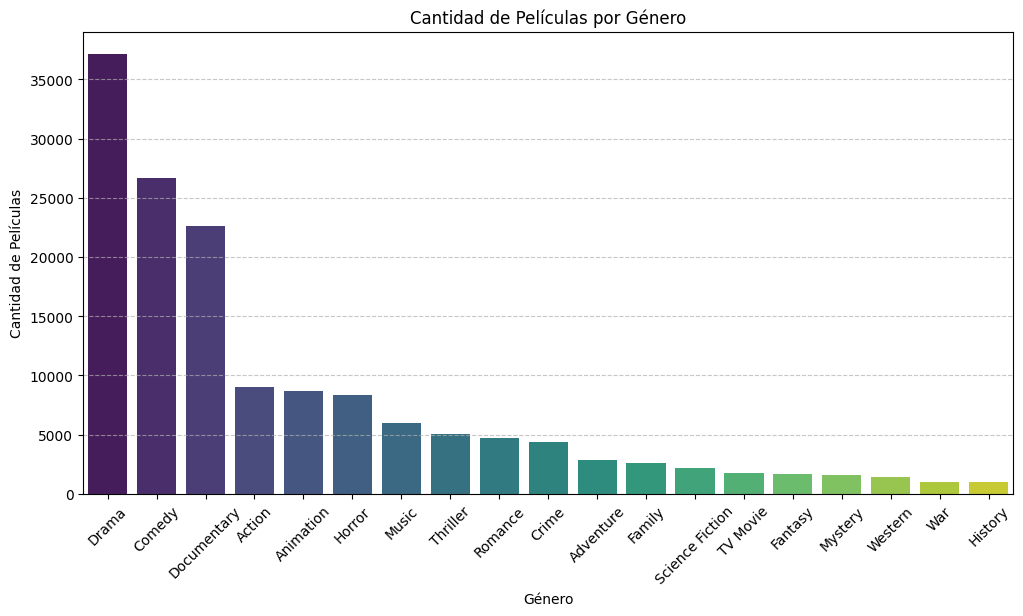

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suponiendo que df_eda_F2 ya está cargado

# Reemplazar valores "nan" (como texto) en 'genre_1' con el valor de 'genre_2'
df_eda_F2["genre_1"] = df_eda_F2.apply(
    lambda row: row["genre_2"] if str(row["genre_1"]).strip().lower() == "nan" else row["genre_1"], 
    axis=1
)

# Contar el número de películas por género
df_genre_count = df_eda_F2.explode("genre_1")["genre_1"].value_counts().reset_index()
df_genre_count.columns = ["Género", "Cantidad de Películas"]

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x=df_genre_count["Género"], y=df_genre_count["Cantidad de Películas"], palette="viridis")

plt.title("Cantidad de Películas por Género")
plt.xlabel("Género")
plt.ylabel("Cantidad de Películas")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.show()




C:\Users\Alejandro Arteaga\AppData\Local\Temp\ipykernel_1280\1728384119.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Género", y="Promedio de Puntuación", data=df_genre_avg, palette="coolwarm")


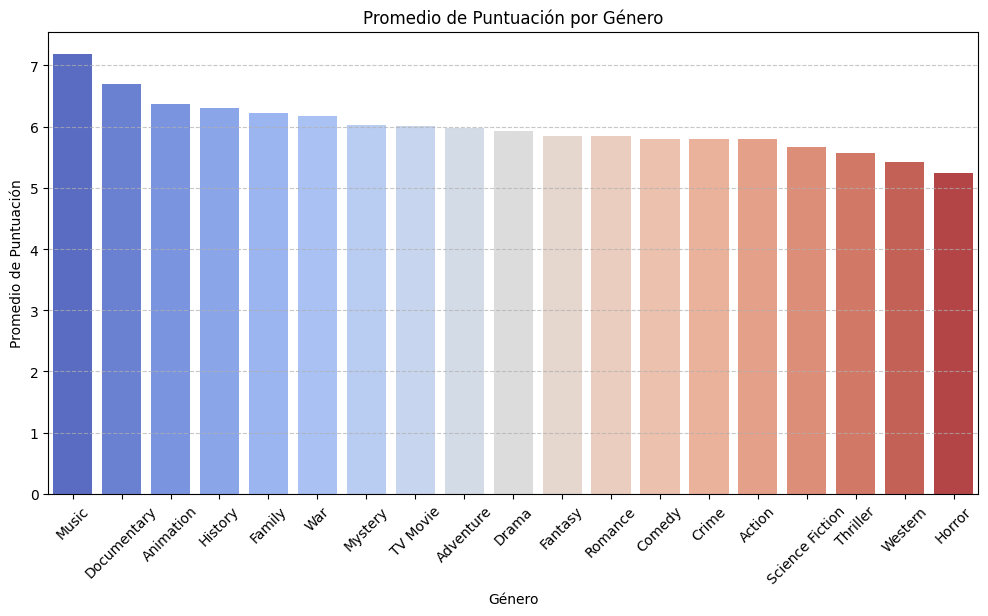

In [28]:
# Calcular el promedio de puntuación por género
df_genre_avg = df_eda_F2.explode("genre_1").groupby("genre_1")["vote_average"].mean().reset_index()
df_genre_avg.columns = ["Género", "Promedio de Puntuación"]
df_genre_avg = df_genre_avg.sort_values(by="Promedio de Puntuación", ascending=False)  # Ordenar de mayor a menor

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x="Género", y="Promedio de Puntuación", data=df_genre_avg, palette="coolwarm")

# Personalización del gráfico
plt.title("Promedio de Puntuación por Género")
plt.xlabel("Género")
plt.ylabel("Promedio de Puntuación")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.show()

C:\Users\Alejandro Arteaga\AppData\Local\Temp\ipykernel_1280\849161558.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="genre_1", y="budget", data=df_genre_profit, palette="viridis")


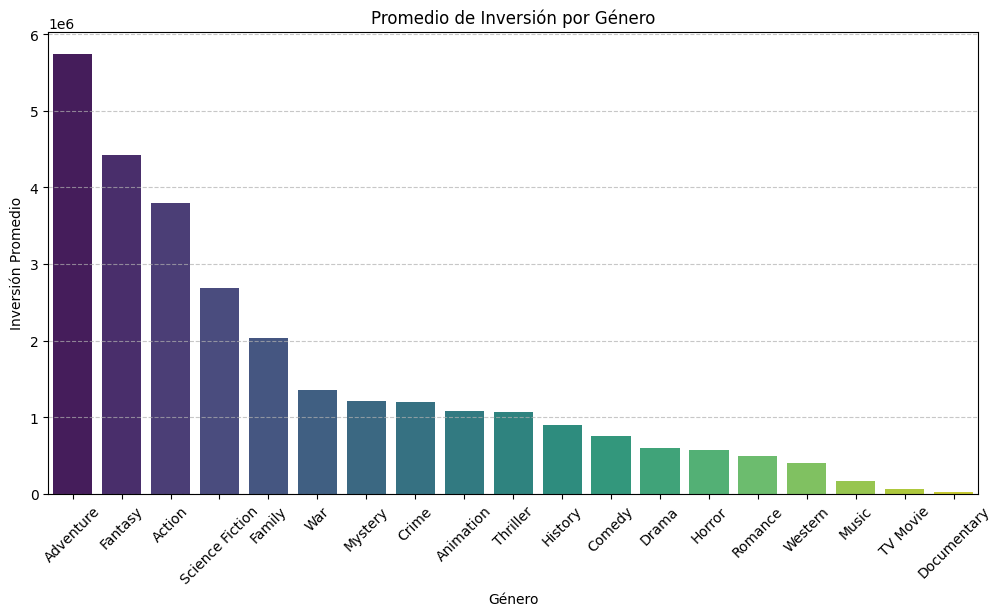

In [29]:
# Reemplazar valores "nan" (como texto) en 'genre_1' con el valor de 'genre_2'
df_eda_F2["genre_1"] = df_eda_F2.apply(
    lambda row: row["genre_2"] if str(row["genre_1"]).strip().lower() == "nan" else row["genre_1"], 
    axis=1
)

# Agrupar por género y calcular el promedio de inversión
df_genre_profit = df_eda_F2.groupby("genre_1")["budget"].mean().reset_index()

# Ordenar de mayor a menor
df_genre_profit = df_genre_profit.sort_values(by="budget", ascending=False)

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x="genre_1", y="budget", data=df_genre_profit, palette="viridis")

# Personalización del gráfico
plt.title("Promedio de Inversión por Género")
plt.xlabel("Género")
plt.ylabel("Inversión Promedio")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.show()

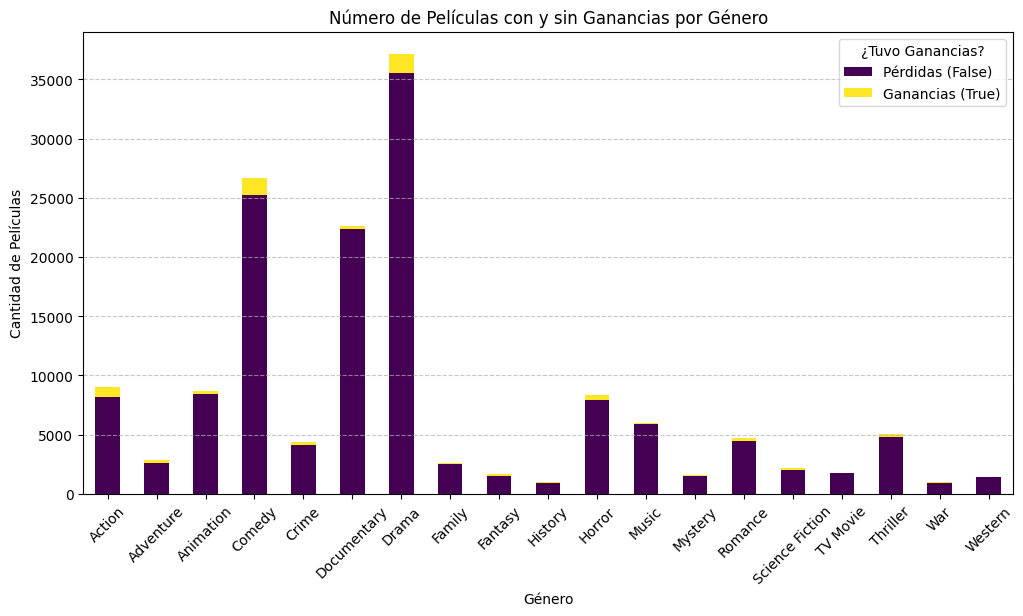

In [30]:
#Se obtiene un grafico para observar del total de peloculas por genero, cuantas fueron rentables y cuantas no
# Reemplazar valores "nan" (como texto) en 'genre_1' con el valor de 'genre_2'
df_eda_F2["genre_1"] = df_eda_F2.apply(
    lambda row: row["genre_2"] if str(row["genre_1"]).strip().lower() == "nan" else row["genre_1"], 
    axis=1
)

# Contar cuántas películas por género tuvieron o no ganancias
df_genre_profit_count = df_eda_F2.groupby(["genre_1", "has_profit"]).size().unstack(fill_value=0)

# Crear el gráfico de barras apiladas
df_genre_profit_count.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="viridis")

# Personalización del gráfico
plt.title("Número de Películas con y sin Ganancias por Género")
plt.xlabel("Género")
plt.ylabel("Cantidad de Películas")
plt.xticks(rotation=45)
plt.legend(["Pérdidas (False)", "Ganancias (True)"], title="¿Tuvo Ganancias?")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.show()

In [31]:
# Contar la cantidad de películas por idioma y obtener los 5 idiomas con más películas
top_languages = df_eda_F2["original_language"].value_counts().head(5)

# Convertir a DataFrame para mejor visualización
top_languages_df = top_languages.reset_index()
top_languages_df.columns = ["Idioma", "Cantidad de Películas"]

# Mostrar la tabla
print(top_languages_df)

  Idioma  Cantidad de Películas
0     en                  84011
1     es                  12432
2     fr                  11992
3     de                   7706
4     ja                   6718
